In [1]:
import numpy as np
import torch
import os
import net
import utils
from PIL import Image
from tqdm import tqdm
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image, make_grid
from time import time
import pickle
import random
from pathlib import Path

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [2]:
BATCH_SIZE = 32
DS_FOLDER = "/home/ML_courses/03683533_2021/dataset"
LR = 5e-5
DEVICE_ID = 0
VAL_RANGE = 1000
TRAIN_RANGE = None
NUM_WORKERS = 16
NUM_EPOCHS = 40
SHUFFLE = False
RUN_NAME = f'Alex-LR-{LR}'

# Network and optimizer

In [3]:
model = net.AutoEncoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
device = f'cuda:{DEVICE_ID}' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)

cuda:0


AutoEncoder(
  (activation): LeakyReLU(negative_slope=0.01)
  (last_activation): Sigmoid()
  (enc1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(4, 4))
  (enc1_bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (enc2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (enc2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
  (enc3_bn): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1))
  (enc4_bn): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc5_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

# Data Loader & Dataset

In [4]:
transform = transforms.Compose([transforms.Resize(256),
                                transforms.ToTensor(),
                                ])

class UniDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        x = Image.open(image_path)
        if self.transform is not None:
            x = self.transform(x)
        return x
    
    def __len__(self):
        return len(self.image_paths)

In [5]:
val_files = [os.path.join(DS_FOLDER,i) for i in sorted(os.listdir(DS_FOLDER))[:VAL_RANGE]]
if TRAIN_RANGE != None:
    train_files = [os.path.join(DS_FOLDER,i) for i in 
                   sorted(os.listdir(DS_FOLDER))[VAL_RANGE+1:TRAIN_RANGE+1+VAL_RANGE]]
else:
    train_files = [os.path.join(DS_FOLDER,i) for i in sorted(os.listdir(DS_FOLDER))[VAL_RANGE+1:]]

In [6]:
val_ds = UniDataset(val_files, transform=transform)
train_ds = UniDataset(train_files, transform=transform)

In [7]:
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True, shuffle=SHUFFLE)

# Train model

In [8]:
def save_imgs(true_imgs, val_imgs, dirname, epoch):
    path = os.path.join('results', RUN_NAME, epoch)
    os.makedirs(path, exist_ok=True)
    save_image(val_imgs, os.path.join(path, 'val_pred.png'))
    save_image(true_imgs, os.path.join(path, 'val_true.png'))

In [9]:
def calc_val_loss(val_dl, epoch, dirname):
    with torch.no_grad():
        val_loss = 0.0
        for images in val_dl:
            images = images.float().to(device)
            outputs = model(images)
            images.require_grad = False
            loss = criterion(outputs, images)
            val_loss += loss.item()
    images = images.cpu()
    outputs = outputs.view(outputs.size(0), 3, 256, 256).cpu().data
    save_imgs(images, outputs, dirname, epoch)
    return val_loss/len(val_dl), make_grid(images), make_grid(outputs)

In [10]:
%%time

train_losses = {}
val_losses = {}
for epoch in range(1, NUM_EPOCHS+1):
    t = time()
    train_loss = 0.0
    for images in tqdm(train_dl):
        images = images.float()
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    val_loss, val_true_grid, val_pred_grid = calc_val_loss(val_dl, str(epoch), RUN_NAME)
    train_loss = train_loss/len(train_dl)
    train_losses[epoch] = train_loss
    val_losses[epoch] = val_loss
    print('Epoch: {} \tTraining Loss: {:.6f} \tVal Loss: {:.6f}\t \
    in time {:2f}m'.format(epoch, train_loss, val_loss, (time()-t)/60))


100%|██████████| 1219/1219 [01:15<00:00, 16.13it/s]


Epoch: 1 	Training Loss: 0.050040 	Val Loss: 0.032254	     in time 1.293422m


100%|██████████| 1219/1219 [01:16<00:00, 15.93it/s]


Epoch: 2 	Training Loss: 0.022244 	Val Loss: 0.015805	     in time 1.308561m


100%|██████████| 1219/1219 [01:16<00:00, 15.93it/s]


Epoch: 3 	Training Loss: 0.012539 	Val Loss: 0.010472	     in time 1.309420m


100%|██████████| 1219/1219 [01:16<00:00, 15.94it/s]


Epoch: 4 	Training Loss: 0.009025 	Val Loss: 0.008104	     in time 1.308036m


100%|██████████| 1219/1219 [01:16<00:00, 15.89it/s]


Epoch: 5 	Training Loss: 0.007292 	Val Loss: 0.006806	     in time 1.312042m


100%|██████████| 1219/1219 [01:16<00:00, 16.00it/s]


Epoch: 6 	Training Loss: 0.006260 	Val Loss: 0.005927	     in time 1.303624m


100%|██████████| 1219/1219 [01:16<00:00, 15.94it/s]


Epoch: 7 	Training Loss: 0.005561 	Val Loss: 0.005343	     in time 1.309022m


100%|██████████| 1219/1219 [01:16<00:00, 16.02it/s]


Epoch: 8 	Training Loss: 0.005098 	Val Loss: 0.004953	     in time 1.300578m


100%|██████████| 1219/1219 [01:16<00:00, 15.97it/s]


Epoch: 9 	Training Loss: 0.004780 	Val Loss: 0.004679	     in time 1.305432m


100%|██████████| 1219/1219 [01:16<00:00, 15.95it/s]


Epoch: 10 	Training Loss: 0.004540 	Val Loss: 0.004461	     in time 1.307383m


100%|██████████| 1219/1219 [01:16<00:00, 15.98it/s]


Epoch: 11 	Training Loss: 0.004340 	Val Loss: 0.004286	     in time 1.304961m


100%|██████████| 1219/1219 [01:16<00:00, 16.02it/s]


Epoch: 12 	Training Loss: 0.004142 	Val Loss: 0.004075	     in time 1.301454m


100%|██████████| 1219/1219 [01:16<00:00, 15.90it/s]


Epoch: 13 	Training Loss: 0.003954 	Val Loss: 0.003904	     in time 1.311251m


100%|██████████| 1219/1219 [01:16<00:00, 16.02it/s]


Epoch: 14 	Training Loss: 0.003800 	Val Loss: 0.003784	     in time 1.301068m


100%|██████████| 1219/1219 [01:16<00:00, 16.00it/s]


Epoch: 15 	Training Loss: 0.003697 	Val Loss: 0.003700	     in time 1.303036m


100%|██████████| 1219/1219 [01:16<00:00, 15.93it/s]


Epoch: 16 	Training Loss: 0.003622 	Val Loss: 0.003632	     in time 1.308294m


100%|██████████| 1219/1219 [01:16<00:00, 15.97it/s]


Epoch: 17 	Training Loss: 0.003554 	Val Loss: 0.003578	     in time 1.305331m


100%|██████████| 1219/1219 [01:16<00:00, 15.91it/s]


Epoch: 18 	Training Loss: 0.003493 	Val Loss: 0.003509	     in time 1.310881m


100%|██████████| 1219/1219 [01:16<00:00, 15.86it/s]


Epoch: 19 	Training Loss: 0.003442 	Val Loss: 0.003456	     in time 1.314322m


100%|██████████| 1219/1219 [01:16<00:00, 15.88it/s]


Epoch: 20 	Training Loss: 0.003393 	Val Loss: 0.003410	     in time 1.312253m


100%|██████████| 1219/1219 [01:16<00:00, 15.89it/s]


Epoch: 21 	Training Loss: 0.003361 	Val Loss: 0.003375	     in time 1.312487m


100%|██████████| 1219/1219 [01:16<00:00, 15.89it/s]


Epoch: 22 	Training Loss: 0.003319 	Val Loss: 0.003348	     in time 1.312344m


100%|██████████| 1219/1219 [01:16<00:00, 15.92it/s]


Epoch: 23 	Training Loss: 0.003290 	Val Loss: 0.003313	     in time 1.309708m


100%|██████████| 1219/1219 [01:16<00:00, 15.99it/s]


Epoch: 24 	Training Loss: 0.003270 	Val Loss: 0.003269	     in time 1.304072m


100%|██████████| 1219/1219 [01:16<00:00, 15.95it/s]


Epoch: 25 	Training Loss: 0.003240 	Val Loss: 0.003259	     in time 1.313337m


100%|██████████| 1219/1219 [01:16<00:00, 15.99it/s]


Epoch: 26 	Training Loss: 0.003202 	Val Loss: 0.003272	     in time 1.311300m


100%|██████████| 1219/1219 [01:16<00:00, 15.89it/s]


Epoch: 27 	Training Loss: 0.003173 	Val Loss: 0.003266	     in time 1.314409m


100%|██████████| 1219/1219 [01:16<00:00, 15.95it/s]


Epoch: 28 	Training Loss: 0.003146 	Val Loss: 0.003203	     in time 1.310065m


100%|██████████| 1219/1219 [01:17<00:00, 15.82it/s]


Epoch: 29 	Training Loss: 0.003128 	Val Loss: 0.003177	     in time 1.319347m


100%|██████████| 1219/1219 [01:16<00:00, 16.01it/s]


Epoch: 30 	Training Loss: 0.003112 	Val Loss: 0.003162	     in time 1.303613m


100%|██████████| 1219/1219 [01:16<00:00, 15.89it/s]


Epoch: 31 	Training Loss: 0.003090 	Val Loss: 0.003120	     in time 1.313386m


100%|██████████| 1219/1219 [01:16<00:00, 15.89it/s]


Epoch: 32 	Training Loss: 0.003069 	Val Loss: 0.003098	     in time 1.316099m


100%|██████████| 1219/1219 [01:16<00:00, 15.87it/s]


Epoch: 33 	Training Loss: 0.003050 	Val Loss: 0.003133	     in time 1.315289m


100%|██████████| 1219/1219 [01:16<00:00, 15.98it/s]


Epoch: 34 	Training Loss: 0.003019 	Val Loss: 0.003055	     in time 1.306259m


100%|██████████| 1219/1219 [01:16<00:00, 16.00it/s]


Epoch: 35 	Training Loss: 0.002994 	Val Loss: 0.003047	     in time 1.303333m


100%|██████████| 1219/1219 [01:16<00:00, 15.96it/s]


Epoch: 36 	Training Loss: 0.002969 	Val Loss: 0.003016	     in time 1.303851m


100%|██████████| 1219/1219 [01:15<00:00, 16.09it/s]


Epoch: 37 	Training Loss: 0.002949 	Val Loss: 0.003017	     in time 1.293610m


100%|██████████| 1219/1219 [01:15<00:00, 16.12it/s]


Epoch: 38 	Training Loss: 0.002936 	Val Loss: 0.003044	     in time 1.291256m


100%|██████████| 1219/1219 [01:15<00:00, 16.07it/s]


Epoch: 39 	Training Loss: 0.002924 	Val Loss: 0.002985	     in time 1.294081m


100%|██████████| 1219/1219 [01:15<00:00, 16.12it/s]


Epoch: 40 	Training Loss: 0.002904 	Val Loss: 0.002990	     in time 1.291499m
CPU times: user 44min 7s, sys: 14min 28s, total: 58min 35s
Wall time: 52min 16s


# Results

In [11]:
def show(img, ax = None):
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
path = Path("results") / RUN_NAME

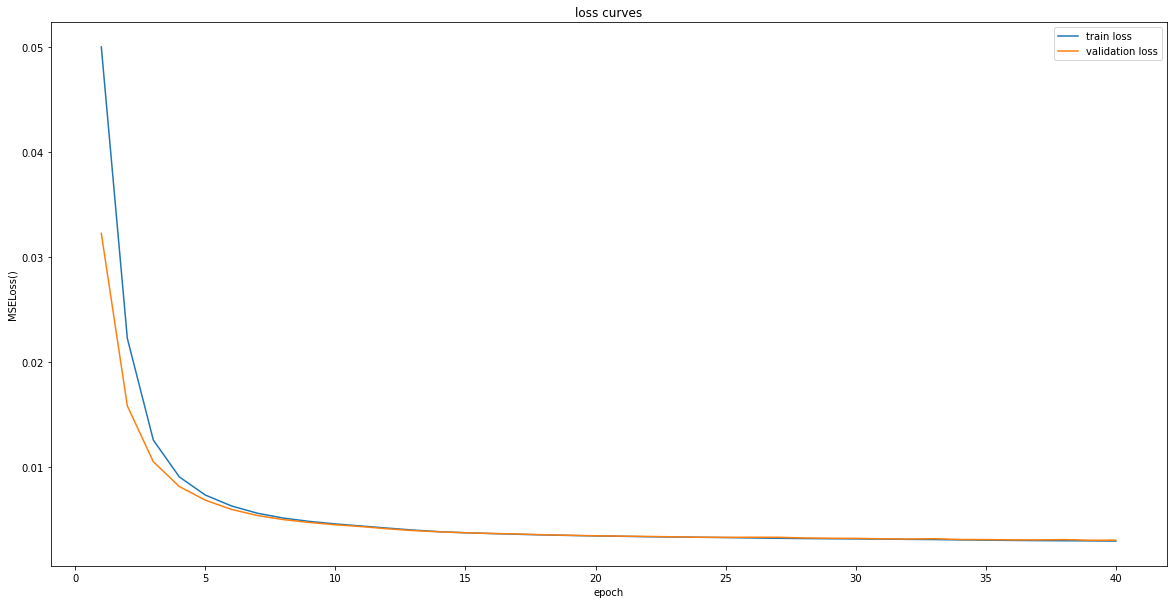

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(train_losses.keys(), train_losses.values(), label="train loss")
plt.plot(val_losses.keys(), val_losses.values(), label="validation loss")
plt.title("loss curves")
plt.legend()
plt.xlabel("epoch")
plt.ylabel(str(criterion))
plt.savefig(path / "loss_curves.png")

In [13]:
with open(path / "loss_values.txt", "w") as f:
    for i in train_losses.keys():
        f.write(f"epoch {i}: train loss is {train_losses[i]:.6f}, validation loss is {val_losses[i]:.6f}\n")

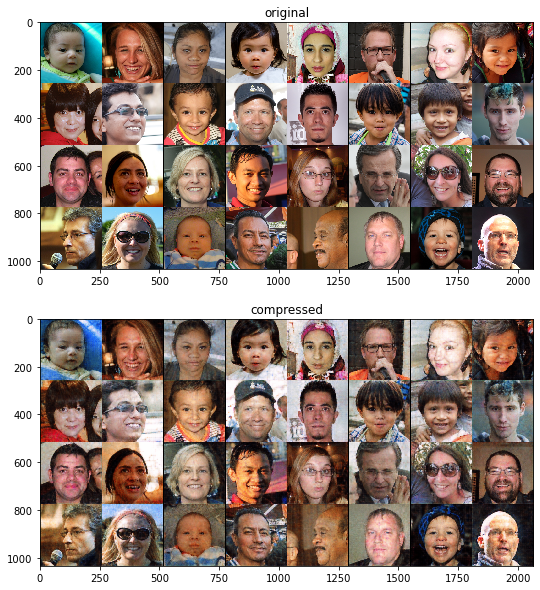

In [14]:
images = list(val_dl)[0]
outputs = model(images.to(device)).cpu()

fig, axes = plt.subplots(2, figsize=(20, 10))
show(make_grid(images), axes[0])
axes[0].set_title("original")
show(make_grid(outputs), axes[1])
axes[1].set_title("compressed")
plt.savefig( path / 'validation_compare.png')